In [5]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization

from tcn import TCN


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Filters parameters
minFilters = 32
maxFilters = 128
stepsFilters = 32
defaultFilters = 32

# Kernels parameters
minKernels = 2
maxKernels = 5
stepsKernels = 1
defaultKernels = 3

# Dilations parameters
dilations = [1, 2, 4, 8, 16]

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = 0.25

# Establish loss measure
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 40
executions = 2

# Epochs
epchs = 100

TF version: 2.15.0
KT version: 1.0.5
Panda version: 2.2.0
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Please install GPU version of TF
Num GPUs Available:  0
Build with CUDA:  False


C:\Users\hecto\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [6]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
#                    delimiter=",")

# projectNameBO = "W7_PV-tcn-bo"
# projectNameRS = "W7_PV-tcn-rs"

# projectNameRS = "PV_W140_H20-tcn-rs"
# projectNameBO = "PV_W140_H20-tcn-bo"

projectNameRS = "CPU-PV_W20_H20-tcn-rs"
projectNameBO = "CPU-PV_W20_H20-tcn-bo"

W=20
H=20

In [7]:
# Preprocessing for PV_W_H type files:

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

#  Uncomment in order to normalize data
# Data Normalization

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)

           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9         10        11        12        13  

In [8]:
# # W type data preprocessing:

# # Y will be the next day pv data, aka the last column from the next row.
# shifted_df = X.shift(-1)
# Y = pd.DataFrame(shifted_df.iloc[:, -1])

# shifted_df = xTest.shift(-1)
# yTest = pd.DataFrame(shifted_df.iloc[:, -1])

# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# xTest.drop(xTest.tail(1).index, inplace = True)
# yTest.drop(yTest.tail(1).index, inplace = True)

# numPredictions = 1

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# print("X: ", X)
# print("Y: ", Y)

In [9]:
# # Old Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

In [10]:


# numPredictions = H

# df = df.replace(',', '.', regex=True)
# dfTest = dfTest.replace(',', '.', regex=True)

# # Data normalization
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df))
# dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# # Merge the two data sources
# X = pd.concat([X, df], axis = 1)
# xTest = pd.concat([xTest, dfTest], axis = 1)

# print("Source shape: ", X.shape)

# # NaN treatment
# if W == 1:
#     X.drop(X.tail(W).index, inplace = True)
#     xTest.drop(xTest.tail(W).index, inplace = True)
# else :
#     X.drop(X.tail(W-1).index, inplace = True)
#     xTest.drop(xTest.tail(W-1).index, inplace = True)


# # Y will contain only the last H columns, the data from the following day
# Y = X.iloc[:, -H:]
# yTest = xTest.iloc[:, -H:]

# # X will contain the rest of the data
# X = X.iloc[:, :-H]
# xTest = xTest.iloc[:, :-H]


# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

In [11]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use TCN (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9   ...        30  

In [12]:

# Model definition:
# with tf.device('/gpu:0'): 

def build_model(hp): 

    model = Sequential()
    
    # First layer: TCN. Number of nb_filters, kernel_size, and dilations optimization.
    model.add(TCN(nb_filters = hp.Int('filters', 
                                min_value = minFilters,
                                max_value = maxFilters, 
                                step = stepsFilters,
                                default = defaultFilters),
                    kernel_size = hp.Int('kernel_size', 
                                min_value = minKernels,
                                max_value = maxKernels, 
                                step = stepsKernels,
                                default = defaultKernels),
                    dilations = dilations,
                    return_sequences = True, 
                    input_shape = (xtrain.shape[1], xtrain.shape[2])))

    # Second layer: Dropout with percetange optimization
    model.add(
        Dropout(hp.Float('dropout', 
                        min_value = minDropout,
                        max_value = maxDropout,
                        default = defaultDropout)))
    
    # Last layer:
    model.add(Dense(numPredictions))

    # # Set Epsilon to 1, in order to fix huge MAPE values.
    # keras.backend.set_epsilon(1)

    # Model compilation: learning rate optimization
    model.compile(loss = loss,
                optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values = learningRate)),
                metrics = modelMetrics)

    return model

In [13]:
# Model training:
# with tf.device('/gpu:0'): 
    # Create optimizer
tcnOptimizer = RandomSearch(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameRS,
                            overwrite=True)

# Search space summary
# tcnOptimizer.search_space_summary()

# Search execution with epochs
initialTime = time.time()
tcnOptimizer.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data=(xval, yval),
                    verbose  = 1)
finalTime = time.time()

# Get best model generated
model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data=(xval, yval))

# Show model info
print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 36s]
val_mean_absolute_error: 0.2237159088253975

Best val_mean_absolute_error So Far: 0.20627613365650177
Total elapsed time: 00h 17m 39s

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.1375 - mean_absolute_error: 0.1375 - rmse: 0.2193 - val_loss: 0.2042 - val_mean_absolute_error: 0.2042 - val_rmse: 0.2617
Epoch 2/100
1/1 [==============================] - 0s 109ms/step - loss: 0.1368 - mean_absolute_error: 0.1368 - rmse: 0.1807 - val_loss: 0.2048 - val_mean_absolute_error: 0.2048 - val_rmse: 0.2644
Epoch 3/100
1/1 [==============================] - 0s 109ms/step - loss: 0.1349 - mean_absolute_error: 0.1349 - rmse: 0.1791 - val_loss: 0.2072 - val_mean_absolute_error: 0.2072 - val_rmse: 0.2650
Epoch 4/100
1/1 [==============================] - 0s 108ms/step - loss: 0.1336 - mean_absolute_error: 0.1336 - rmse: 0.1787 - val_loss: 0.2092 - val_mean_absolute_error: 0.2092 - val_rmse: 0.2665
Epoch 5/100
1/1 [==============================]

------------------------------------------------------
SUMMARY
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	1058.6965777873993


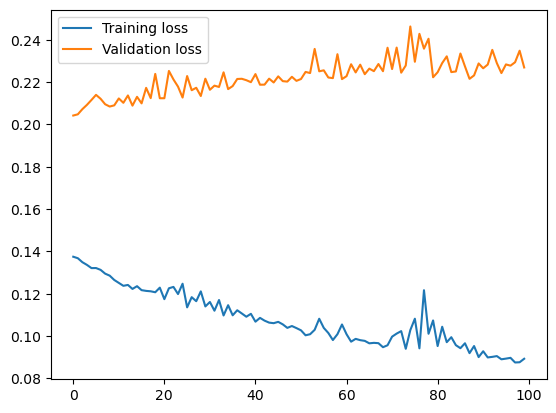

Results summary
Results in .\CPU-PV_W20_H20-tcn-rs
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 38 summary
Hyperparameters:
filters: 128
kernel_size: 3
dropout: 0.026061202180924323
learning_rate: 0.01
Score: 0.20627613365650177
12/12 [==============================] - 0s 4ms/step - loss: 0.1706 - mean_absolute_error: 0.1706 - rmse: 0.2291
Score: [0.17064861953258514, 0.17064861953258514, 0.2290624976158142]


In [14]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
tcnOptimizer.results_summary(num_trials = 1)

# Model evaluation with test data
score = model.evaluate(xtest, ytest)
print('Score:', score)

In [15]:
# Model training:
# with tf.device('/gpu:0'): 
    # Create optimizer
tcnOptimizerBO = BayesianOptimization(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameBO,
                            overwrite=True)

# Search space summary
# tcnOptimizerBO.search_space_summary()

# Search execution with epochs
initialTime = time.time()
tcnOptimizerBO.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data=(xval, yval),
                    verbose = 1)
finalTime = time.time()

# Get best model generated
model = tcnOptimizerBO.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data=(xval, yval))

# Show model info
print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 31s]
val_mean_absolute_error: 0.22235775738954544

Best val_mean_absolute_error So Far: 0.20853079855442047
Total elapsed time: 00h 20m 15s
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.1266 - mean_absolute_error: 0.1266 - rmse: 0.2161 - val_loss: 0.2200 - val_mean_absolute_error: 0.2200 - val_rmse: 0.2663
Epoch 2/100
1/1 [==============================] - 0s 45ms/step - loss: 0.1280 - mean_absolute_error: 0.1280 - rmse: 0.1659 - val_loss: 0.2125 - val_mean_absolute_error: 0.2125 - val_rmse: 0.2649
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 0.1226 - mean_absolute_error: 0.1226 - rmse: 0.1651 - val_loss: 0.2099 - val_mean_absolute_error: 0.2099 - val_rmse: 0.2781
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 0.1311 - mean_absolute_error: 0.1311 - rmse: 0.1832 - val_loss: 0.2169 - val_mean_absolute_error: 0.2169 - val_rmse: 0.2665
Epoch 5/100
1/1 [==============================] - 

------------------------------------------------------
SUMMARY BO
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	1214.6989891529083


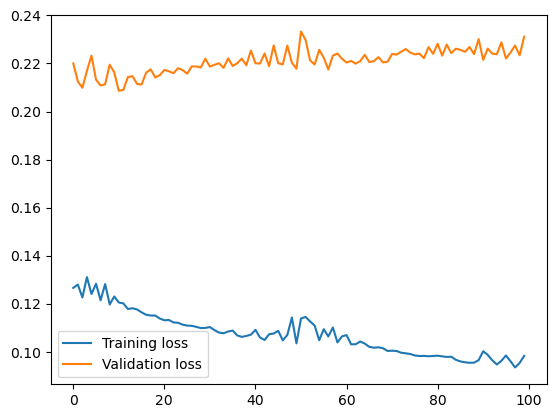

Results summary
Results in .\CPU-PV_W20_H20-tcn-bo
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 30 summary
Hyperparameters:
filters: 32
kernel_size: 5
dropout: 0.0
learning_rate: 0.01
Score: 0.20853079855442047
12/12 [==============================] - 0s 3ms/step - loss: 0.1735 - mean_absolute_error: 0.1735 - rmse: 0.2296
Score: [0.1734669953584671, 0.1734669953584671, 0.22956837713718414]


In [16]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY BO")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
tcnOptimizerBO.results_summary(num_trials = 1)

# Model evaluation with test data
score = model.evaluate(xtest, ytest)
print('Score:', score)